# Analizzare i Documenti sul COVID-19

In questa sfida, continueremo con il tema della pandemia di COVID, concentrandoci sull'elaborazione di articoli scientifici sull'argomento. Esiste il [Dataset CORD-19](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) con più di 7000 articoli (al momento della stesura) sul COVID, disponibile con metadati e abstract (e per circa la metà di essi è fornito anche il testo completo).

Un esempio completo di analisi di questo dataset utilizzando il servizio cognitivo [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) è descritto [in questo post sul blog](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/). Discuteremo una versione semplificata di questa analisi.


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Ottenere i Dati

Per prima cosa, dobbiamo ottenere i metadati dei documenti CORD con cui lavoreremo.

**NOTA**: Non forniamo una copia del dataset come parte di questo repository. Potresti dover scaricare il file [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) da [questo dataset su Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). Potrebbe essere necessaria la registrazione su Kaggle. Puoi anche scaricare il dataset senza registrazione [da qui](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html), ma includerà tutti i testi completi oltre al file dei metadati.

Cercheremo di ottenere i dati direttamente dalla fonte online, tuttavia, se non dovesse funzionare, dovrai scaricare i dati come descritto sopra. Inoltre, ha senso scaricare i dati se prevedi di sperimentarli ulteriormente, per risparmiare tempo di attesa.

> **NOTA** che il dataset è piuttosto grande, circa 1 Gb di dimensione, e la seguente riga di codice potrebbe richiedere molto tempo per essere completata! (~5 minuti)


In [146]:
df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
# df = pd.read_csv("metadata.csv")
df.head()

C:\winapp\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

Ora convertiremo la colonna della data di pubblicazione in `datetime` e tracceremo l'istogramma per vedere l'intervallo delle date di pubblicazione.


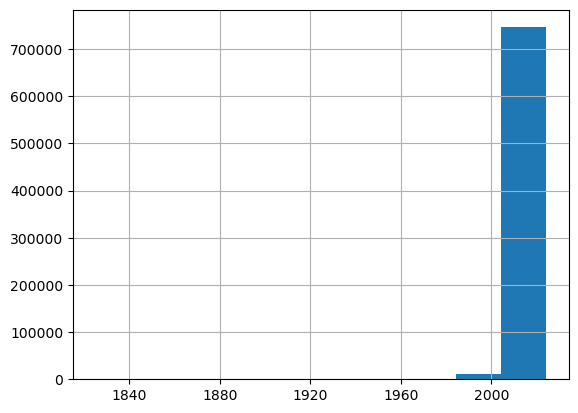

In [147]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'].hist()
plt.show()

## Estrazione di Dati Strutturati

Vediamo che tipo di informazioni possiamo estrarre facilmente dagli abstract. Una cosa che potrebbe interessarci è capire quali strategie di trattamento esistono e come si sono evolute nel tempo. Per iniziare, possiamo compilare manualmente l'elenco dei possibili farmaci utilizzati per trattare il COVID, così come l'elenco delle diagnosi. Successivamente, li esaminiamo e cerchiamo i termini corrispondenti negli abstract degli articoli.


In [148]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


Abbiamo aggiunto una serie di colonne al nostro dataframe che contengono il numero di volte in cui un determinato farmaco/diagnosi è presente nell'abstract.

> **Nota** che aggiungiamo uno spazio all'inizio della parola quando cerchiamo una sottostringa. Se non lo facessimo, potremmo ottenere risultati errati, perché *clorochina* verrebbe trovata anche all'interno della sottostringa *idrossiclorochina*. Inoltre, forziamo la conversione della colonna degli abstract in `str` per eliminare un errore - prova a rimuovere `str` e osserva cosa succede.

Per rendere più semplice il lavoro con i dati, possiamo estrarre il sotto-frame con solo i conteggi dei farmaci e calcolare il numero accumulato di occorrenze. Questo ci dà il farmaco più popolare:


In [149]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine   9806
3           remdesivir   7861
2          tocilizumab   6118
1          chloroquine   4578
8              heparin   4161
5            lopinavir   3811
4         azithromycin   3585
7        dexamethasone   3340
9          favipiravir   2439
10  methylprednisolone   1600
6            ritonavir    948

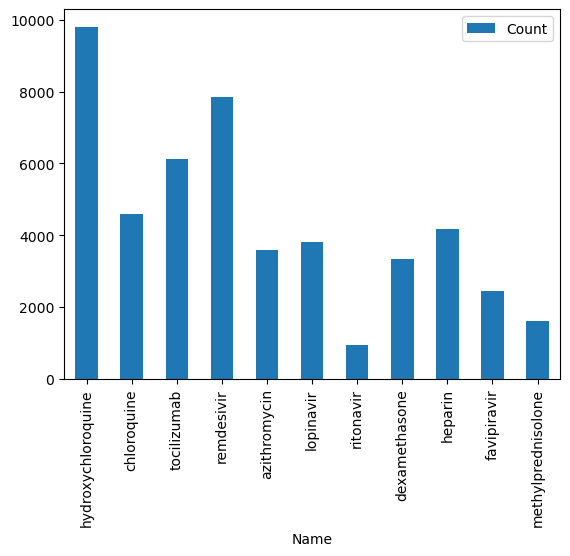

In [150]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## Ricerca di tendenze nella strategia di trattamento

Nell'esempio sopra abbiamo calcolato la `somma` di tutti i valori, ma possiamo fare lo stesso su base mensile:


In [151]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3672         1773         1779   
             2                              0           19            0   
             3                             45           72            5   
             4                            188          238           50   
             5                            459          191          158   
             6                            381          149          243   
             7                            381          178          202   
             8                            307          115          172   
             9                            319          123          185   
             10                           319           96          212   
             11                           272           66          170   
             12                           255          102          229   
2021         1                           2191          780         1787   
             2                            163           66          184   
             3                            172           85          190   
             4                            198           70          125   
             5                            141           55          138   
             6                            144           29          138   
             7                            112           49           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2134          1173       1430        370   
             2                      3             3         18         11   
             3                     27            12         52         16   
             4                    124            68        113         13   
             5                    209           132        135         41   
             6                    186           110        132         18   
             7                    165           108        138         29   
             8                    165           145         91         24   
             9                    190            91         98         28   
             10                   227            72        127         39   
             11                   197            79        104         27   
             12                   271            98         76         31   
2021         1                   2523           892        841        198   
             2                    173            85         76          9   
             3                    295            87        100         17   
             4                    161            83         60         13   
             5                    179            69         55         21   
             6                    182            75         41         12   
             7                    270            64         59          5   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       561      984          666   
             2                         1        3           12   
             3                         3       21           11   
             4                        14       77           48   
             5                        12       92           48   
             6                        48       84           30   
             7                        58      117           56   
             8                        56       95           45   
             9                        90      111           46   
             10                       97      117           81   
             11                       77 

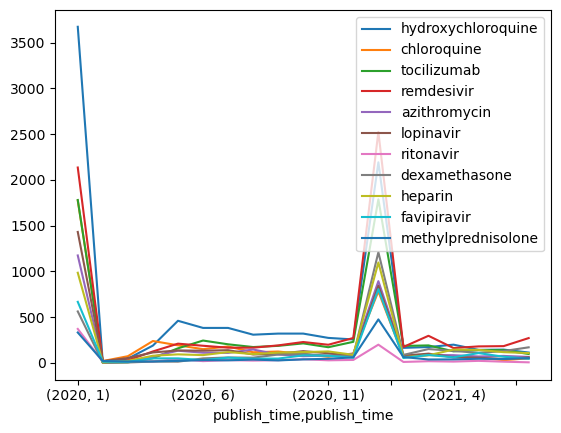

In [152]:
dfmt.plot()
plt.show()

Un'osservazione interessante è che ci sono enormi picchi in due momenti: gennaio 2020 e gennaio 2021. Questo è dovuto al fatto che alcuni articoli non hanno una data di pubblicazione chiaramente specificata e vengono indicati come gennaio dell'anno corrispondente.

Per dare più senso ai dati, visualizziamo solo alcuni farmaci. Inoltre, "cancelleremo" i dati di gennaio e li sostituiremo con un valore medio, per ottenere un grafico più chiaro:


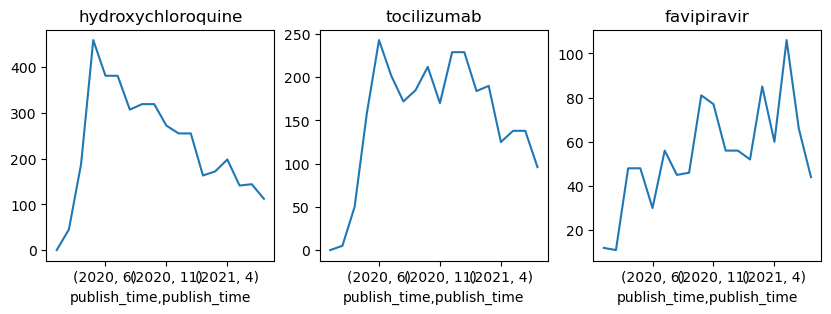

In [153]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

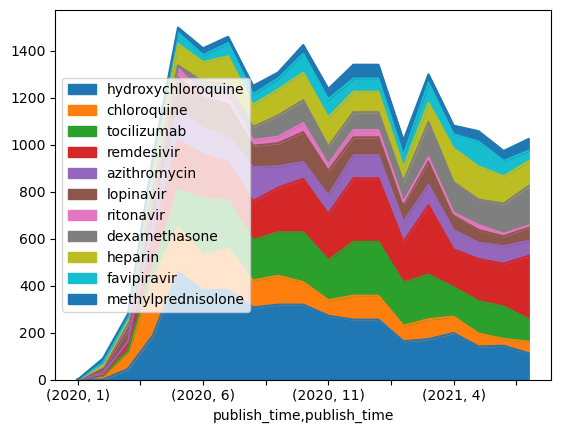

In [154]:
dfmt.plot.area()
plt.show()

Ancora oltre, possiamo calcolare la popolarità relativa in percentuale:


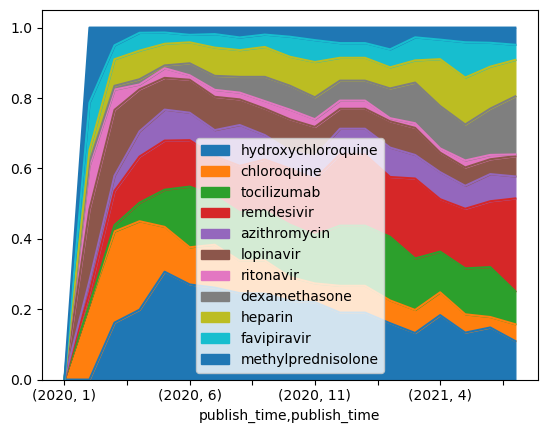

In [155]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()

## Calcolo della Corrispondenza tra Medicina e Diagnosi

Una delle relazioni più interessanti da analizzare è come diverse diagnosi vengano trattate con differenti medicinali. Per visualizzarla, dobbiamo calcolare una **mappa di frequenza di co-occorrenza**, che mostri quante volte due termini vengono menzionati nello stesso articolo.

Questa mappa è essenzialmente una matrice 2D, che è meglio rappresentata da un **array numpy**. Calcoleremo questa mappa analizzando tutti gli abstract e segnando le entità che vi compaiono:


In [156]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [157]:
m

array([[4788., 2264.,  741., 2109.,  348., 2730.,  975.],
       [2111., 1238.,  231.,  998.,   79., 1394.,  364.],
       [2186.,  821.,  691., 1063.,  185., 1136.,  573.],
       [3210., 2191.,  522., 1538.,  160., 2191.,  622.],
       [1803.,  773.,  406.,  880.,  133.,  909.,  410.],
       [1982., 1102.,  379.,  885.,  113., 1366.,  370.],
       [ 504.,  356.,   83.,  259.,   23.,  354.,  106.],
       [1419.,  640.,  345.,  742.,  108.,  760.,  314.],
       [1537.,  678.,  330.,  782.,   93.,  826.,  301.],
       [ 967.,  634.,  201.,  431.,   44.,  656.,  136.],
       [ 660.,  336.,  293.,  385.,   53.,  452.,  148.]])

Uno dei modi per visualizzare questa matrice è disegnare una **mappa di calore**:


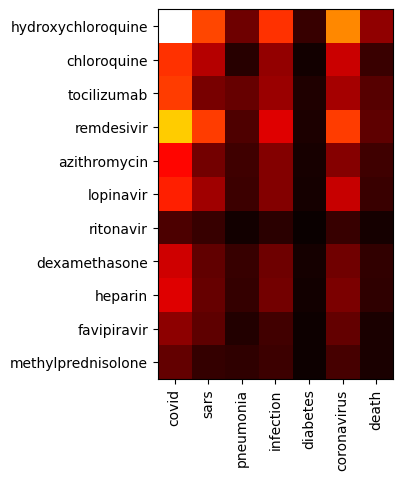

In [158]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

Tuttavia, una visualizzazione ancora migliore può essere ottenuta utilizzando il cosiddetto diagramma **Sankey**! `matplotlib` non ha un supporto integrato per questo tipo di diagramma, quindi dovremo utilizzare [Plotly](https://plotly.com/python/) come descritto [in questo tutorial](https://plotly.com/python/sankey-diagram/).

Per creare un diagramma Sankey con Plotly, dobbiamo costruire le seguenti liste:
* La lista `all_nodes` di tutti i nodi nel grafo, che includerà sia i farmaci che le diagnosi
* Liste di indici di origine e destinazione - queste liste mostreranno quali nodi vanno a sinistra e quali a destra del diagramma
* Lista di tutti i collegamenti, ogni collegamento composto da:
   - Indice di origine nell'array `all_nodes`
   - Indice di destinazione
   - Valore che indica la forza del collegamento. Questo è esattamente il valore della nostra matrice di co-occorrenza.
   - Facoltativamente il colore del collegamento. Creeremo un'opzione per evidenziare alcuni termini per maggiore chiarezza

Il codice generico per disegnare un diagramma Sankey è strutturato come una funzione separata `sankey`, che prende due liste (categorie di origine e destinazione) e una matrice di co-occorrenza. Consente inoltre di specificare una soglia e di omettere tutti i collegamenti che sono più deboli di quella soglia - questo rende il diagramma un po' meno complesso.


In [160]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## Conclusione

Hai visto che possiamo utilizzare metodi piuttosto semplici per estrarre informazioni da fonti di dati non strutturati, come il testo. In questo esempio, abbiamo utilizzato l'elenco esistente di farmaci, ma sarebbe molto più potente impiegare tecniche di elaborazione del linguaggio naturale (NLP) per effettuare l'estrazione di entità dal testo. In [questo post sul blog](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) descriviamo come utilizzare i servizi cloud per l'estrazione di entità. Un'altra opzione potrebbe essere l'uso di librerie NLP di Python come [NLTK](https://www.nltk.org/) - un approccio per estrarre informazioni dal testo utilizzando NLTK è descritto [qui](https://www.nltk.org/book/ch07.html).


## Sfida

Continua a esaminare i dati dei documenti sul COVID seguendo queste linee guida:

1. Costruisci una matrice di co-occorrenza per i diversi farmaci e verifica quali farmaci vengono spesso menzionati insieme (ad esempio, citati nello stesso abstract). Puoi modificare il codice per costruire la matrice di co-occorrenza per farmaci e diagnosi.
1. Visualizza questa matrice utilizzando una heatmap.
1. Come obiettivo aggiuntivo, potresti voler visualizzare la co-occorrenza dei farmaci utilizzando un [diagramma a corde](https://en.wikipedia.org/wiki/Chord_diagram). [Questa libreria](https://pypi.org/project/chord/) potrebbe aiutarti a disegnare un diagramma a corde.
1. Come ulteriore obiettivo aggiuntivo, prova a estrarre i dosaggi dei diversi farmaci (come **400mg** in *assumi 400mg di clorochina al giorno*) utilizzando espressioni regolari e costruisci un dataframe che mostri i diversi dosaggi per i vari farmaci. **Nota**: considera i valori numerici che si trovano in prossimità testuale del nome del farmaco.



---

**Disclaimer**:  
Questo documento è stato tradotto utilizzando il servizio di traduzione automatica [Co-op Translator](https://github.com/Azure/co-op-translator). Sebbene ci impegniamo per garantire l'accuratezza, si prega di notare che le traduzioni automatiche possono contenere errori o imprecisioni. Il documento originale nella sua lingua nativa dovrebbe essere considerato la fonte autorevole. Per informazioni critiche, si raccomanda una traduzione professionale effettuata da un traduttore umano. Non siamo responsabili per eventuali incomprensioni o interpretazioni errate derivanti dall'uso di questa traduzione.
